In [118]:
# skip if you want to import data from cloud
import numpy as np
import copy, random, math
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import time

# importing data locally
# WILL NOT WORK ON GOOGLE COLAB
def import_excel(): 
    #file_path=r'C:\Users\user\Desktop\ai\data_ASAE.xlsx'
    file_path = '/home/david/Desktop/Pratical work - group 15/data_ASAE.xlsx'

    df = pd.read_excel(file_path, sheet_name='distances')
    distances = np.array(df.iloc[1:, 1:].values, dtype=float) #distances-matrix with distances

    df2 = pd.read_excel(file_path, sheet_name='establishments')
    inspection_times=np.array(df2.iloc[:, 8].values) #inspection_times-array with inspection times
    latitudes=np.array(df2.iloc[:, 5].values)
    longitudes=np.array(df2.iloc[:, 6].values)

    # Extract the last column of the DataFrame
    column_data = df2.iloc[:, -1]
    # Convert the column data into a list of lists
    data_list = [[int(x) for x in row.strip('][').split(', ')] for row in column_data]
    # Convert the list of lists into a NumPy array
    schedule = np.array(data_list)
    return distances,inspection_times,schedule, latitudes, longitudes

In [119]:
def generate_random_solution2(n):
    # Generate a random permutation of the numbers from 1 to k
    values = np.random.permutation(np.arange(1, n + 1))
    return [int(x) for x in values]

def generate_population2(population_size,n):
    solutions = []
    for i in range(population_size):
        solutions.append(generate_random_solution2(n))
    return solutions

def generate_neighbor(solution):
    n = len(solution)
    i, j = np.random.randint(n, size=2)
    neighbor = solution.copy()
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor


#Resource allocation minimization
INSPECTION_TIME = 5/60  # it takes 5 min (300 sec) to inspect each establishment

class ResourceAllocationMinimization:
    def __init__(self, distances, inspection_times, schedule, n):
        self.distances = distances
        self.inspection_time = inspection_times / 3600
        self.schedule = schedule
        self.num_establishments = n

    # solution is a list of establishment indices, e.g. [4 1 5 3 2]
    def evaluate_solution(self, solution):
        route = list(solution)
        total_travel_time = self.distances[0][route[0]] / 3600
        total_inspection_time = 0
        total_waiting_time = 0                  
        waiting_time = 0
        current_time = 9 + total_travel_time
        current_vehicle = 1
        visited_nodes = []
        current_node = 0

        # loop through all establishments in the solution
        for i in range(len(route) - 1):
            start = route[i]
            end = route[i + 1]

            # calculate the travel time from the current node to the next node
            travel_time = self.distances[start][end] / 3600

            # if the current vehicle has reached the end of its working day
            if current_time - 9 >= 8 or current_time + travel_time - 9 >= 8:
                current_vehicle += 1
                current_time = 9
                visited_nodes = []
                total_travel_time += self.distances[0][route[i + 1]] / 3600
                current_node = 0
                total_inspection_time += self.inspection_time
                current_time += self.inspection_time

            # calculate the time the vehicle arrives at the next establishment
            arrival_time = current_time + travel_time

            # if the establishment is not yet open, wait until it opens
            while self.schedule[end][int(arrival_time)] == 0 and current_time - 9 <= 8:
                waiting_time += 1
                arrival_time += 1 
                current_time += 1

            # if the establishment is open, perform the inspection and update the current time
            if self.schedule[end][int(arrival_time)] == 1:
                total_inspection_time += self.inspection_time
                current_time = arrival_time + self.inspection_time
            # if the establishment is closed, skip it and go to the next one
            else:
                current_time = arrival_time
                continue

            # update the current node and the visited nodes list
            current_node = end
            visited_nodes.append(current_node)
            total_travel_time += travel_time
         
        total_time = total_travel_time + total_inspection_time + total_waiting_time

        return (-current_vehicle)


def problem2(distances, inspection_time, schedule, n):
    problem = ResourceAllocationMinimization(distances, inspection_time, schedule, n)
    return problem

In [ ]:
def hill_climbing(num_iterations, num_establishments,  log=False):
  start_time = time.time()
  distances,inspection_times,schedule, latitudes, longitudes=import_excel()
  problem=problem2(distances, INSPECTION_TIME, schedule, num_establishments)  
    
  current_solution = generate_population2(1,num_establishments)[0] # In the Hill Climbing algorithm, typically one initial solution is needed
  current_score = problem.evaluate_solution(current_solution)
  
  print(f"Initial solution: {current_solution}, number of vehicles required to inspect all establishments: {-int(current_score)}")
  
  best_solution_iteration = 0 # Iteration on which the best solution was found
  best_score = current_score
  best_solution = current_solution.copy()
  if log:
    print(f"Iteration 0: best score={-int(best_score)}, best solution={best_solution}")  
    
  for i in range(1, num_iterations + 1):
    # Generate neighboring solution
    neighbor_solution = generate_neighbor(current_solution)
    neighbor_score = problem.evaluate_solution(neighbor_solution)
    # Check if neighboring solution is better
    if neighbor_score > current_score:
        current_solution = neighbor_solution
        current_score = neighbor_score

        if neighbor_score > best_score:
            best_solution = neighbor_solution.copy()
            best_solution_iteration = i
            best_score = neighbor_score
            if log:
                    print(f"Iteration {i}: best score={-int(best_score)}, best solution={best_solution}")
        elif log:
            print(f"Iteration {i}: score={neighbor_score}, solution={neighbor_solution}")

    if log:
        print(f"Best score ({-int(best_score)}) found on iteration {best_solution_iteration}")
                

        

  print(f"Final solution: {best_solution} was found on iteration {best_solution_iteration}, number of vehicles required to inspect all establishments: {-int(best_score)}")
  
  end_time = time.time()
  time_running= round(end_time - start_time,3)  

  print(f"total time spent running the algorithm: {time_running} s")
  return current_solution

In [120]:

def generate_neighbor(solution):
    n = len(solution)
    i, j = np.random.randint(n, size=2)
    neighbor = solution.copy()
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

def hill_climbing(num_iterations, num_establishments,  log=False):
  start_time = time.time()
  distances,inspection_times,schedule, latitudes, longitudes=import_excel()
  problem=problem2(distances, INSPECTION_TIME, schedule, num_establishments)  
    
  initial_solution = generate_population2(1,num_establishments)[0] # In the Hill Climbing algorithm, typically one initial solution is needed
  current_solution = initial_solution.copy()
  current_score = problem.evaluate_solution(current_solution)
  if log:
    print(f"Initial solution: {current_solution}, number of vehicles required to inspect all establishments: {-int(current_score)}")
  else:
    print(f"Initial solution. Number of vehicles required to inspect all establishments: {-int(current_score)}")
    
  best_solution_iteration = 0 # Iteration on which the best solution was found
  best_score = current_score
  best_solution = current_solution.copy()
  best_scores = []
    
  if log:
    print(f"Iteration 0: best score={-int(best_score)}, best solution={best_solution}")  
    
  for i in range(1, num_iterations + 1):
    # Generate neighboring solution
    neighbor_solution = generate_neighbor(current_solution)
    neighbor_score = problem.evaluate_solution(neighbor_solution)
    # Check if neighboring solution is better
    if neighbor_score > current_score:
        current_solution = neighbor_solution
        current_score = neighbor_score

        if neighbor_score > best_score:
            best_solution = neighbor_solution.copy()
            best_solution_iteration = i
            best_score = neighbor_score
            if log:
                    print(f"Iteration {i}: best score={-int(best_score)}, best solution={best_solution}")
        elif log:
            print(f"Iteration {i}: score={neighbor_score}, solution={neighbor_solution}")
    best_scores.append(best_score)
    if log:
        print(f"Best score ({-int(best_score)}) found on iteration {best_solution_iteration}")
                

  if log:      
    print(f"Final solution: {best_solution} was found on iteration {best_solution_iteration}, number of vehicles required to inspect all establishments: {-int(best_score)}")
  else:
    print(f"Final solution was found on iteration {best_solution_iteration}, number of vehicles required to inspect all establishments: {-int(best_score)}")
  
  end_time = time.time()
  time_running= round(end_time - start_time,3)  

  # plot evolution data  
  best_scores_positive = [-score for score in best_scores]
  plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
  plt.xlabel('Iterations')
  plt.ylabel('Number of vehicles to inspect all establishments')
  plt.title('Evolution of Best Solution')
  plt.show()    
  
  print(f"total time spent running the algorithm: {time_running} s")
  return current_solution, initial_solution, best_scores_positive

In [121]:
resourceAllocationResult = hill_climbing(200, 100)
best_solution = resourceAllocationResult[0]
initial_solution = resourceAllocationResult[1]

Initial solution. Number of vehicles required to inspect all establishments: 11
Final solution was found on iteration 15, number of vehicles required to inspect all establishments: 10
total time spent running the algorithm: 12.312 s


Initial solution. Number of vehicles required to inspect all establishments: 5
Final solution was found on iteration 0, number of vehicles required to inspect all establishments: 5


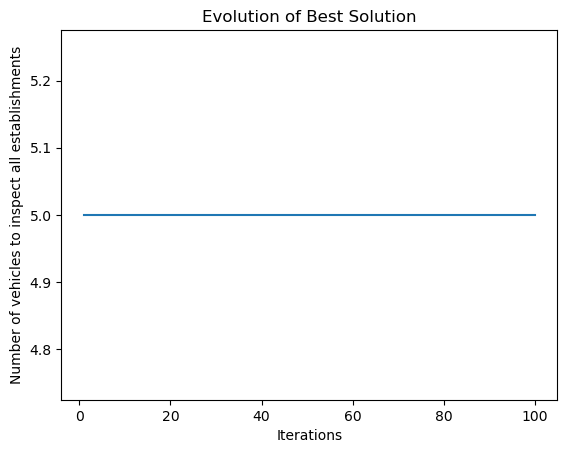

total time spent running the algorithm: 13.731 s


In [112]:
import tkinter as tk
from functools import partial

def run_hill_climbing(num_iterations, num_establishments):
    try:
        num_iterations = int(num_iterations)
        num_establishments = int(num_establishments)
    except ValueError:
        print(f"Invalid input values. Please enter integers. Type provided is {type(num_iterations)} values: {num_iterations}, {num_establishments}")
        return
    # call the hill_climbing function with the provided arguments
    # and print the result
    hill_climbing(num_iterations, num_establishments)

def get_entries_and_run_hill_climbing(iter_entry, est_entry):
    num_iterations = iter_entry.get()
    num_establishments = est_entry.get()
    run_hill_climbing(num_iterations, num_establishments)

# create the main window
root = tk.Tk()
root.title("Hill Climbing")

# create the input widgets
iter_label = tk.Label(root, text="Number of Iterations:")
iter_entry = tk.Entry(root)
est_label = tk.Label(root, text="Number of Establishments:")
est_entry = tk.Entry(root)

# create the button
run_button = tk.Button(root, text="Run",
                       command=partial(get_entries_and_run_hill_climbing,
                                       iter_entry,
                                       est_entry))

# layout the widgets
iter_label.grid(row=0, column=0)
iter_entry.grid(row=0, column=1)
est_label.grid(row=1, column=0)
est_entry.grid(row=1, column=1)
run_button.grid(row=2, column=0, columnspan=2)

# start the event loop
root.mainloop()


Initial solution. Number of vehicles required to inspect all establishments: 6
Final solution was found on iteration 20, number of vehicles required to inspect all establishments: 5


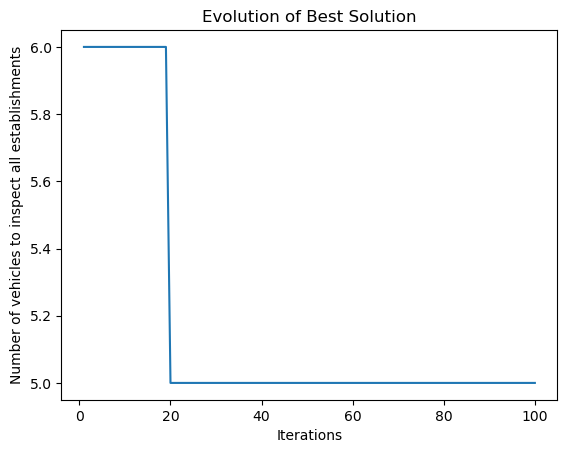

total time spent running the algorithm: 12.805 s


In [114]:
import tkinter as tk
from functools import partial

def run_hill_climbing(num_iterations, num_establishments):
    try:
        num_iterations = int(num_iterations)
        num_establishments = int(num_establishments)
    except ValueError:
        result_label.config(text=f"Invalid input values. Please enter integers. Type provided is {type(num_iterations)} values: {num_iterations}, {num_establishments}")
        return
    # call the hill_climbing function with the provided arguments
    # and print the result
    result = hill_climbing(num_iterations, num_establishments)
    result_label.config(text=f"Result: {result}")

def get_entries_and_run_hill_climbing(iter_entry, est_entry):
    num_iterations = iter_entry.get()
    num_establishments = est_entry.get()
    run_hill_climbing(num_iterations, num_establishments)

# create the main window
root = tk.Tk()
root.title("Hill Climbing")

# create the input widgets
iter_label = tk.Label(root, text="Number of Iterations:")
iter_entry = tk.Entry(root)
est_label = tk.Label(root, text="Number of Establishments:")
est_entry = tk.Entry(root)

# create the button
run_button = tk.Button(root, text="Run",
                       command=partial(get_entries_and_run_hill_climbing,
                                       iter_entry,
                                       est_entry))

# create a label to display the result
result_label = tk.Label(root, text="Result: ")

# layout the widgets
iter_label.grid(row=0, column=0)
iter_entry.grid(row=0, column=1)
est_label.grid(row=1, column=0)
est_entry.grid(row=1, column=1)
run_button.grid(row=2, column=0, columnspan=2)
result_label.grid(row=3, column=0, columnspan=2)

# start the event loop
root.mainloop()


Initial solution. Number of vehicles required to inspect all establishments: 5
Final solution was found on iteration 0, number of vehicles required to inspect all establishments: 5


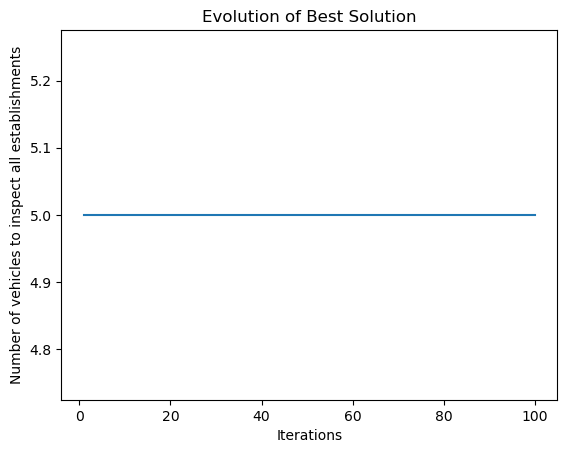

total time spent running the algorithm: 12.197 s


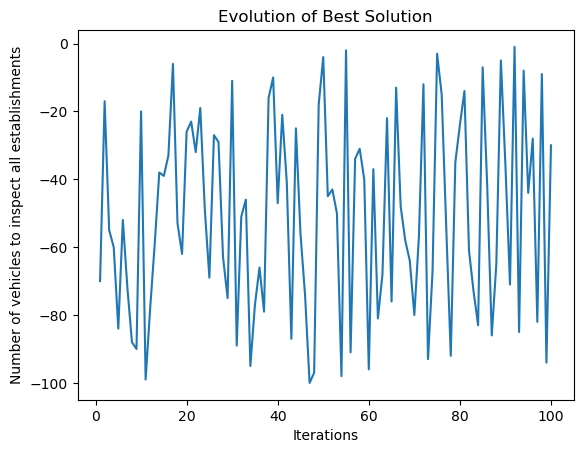

In [116]:
import tkinter as tk
import time
import matplotlib.pyplot as plt
from functools import partial

def run_hill_climbing(num_iterations, num_establishments):
    try:
        num_iterations = int(num_iterations)
        num_establishments = int(num_establishments)
    except ValueError:
        result_label.config(text=f"Invalid input values. Please enter integers. Type provided is {type(num_iterations)} values: {num_iterations}, {num_establishments}")
        return
    # call the hill_climbing function with the provided arguments
    # and print the result
    start_time = time.time()
    best_solution, best_scores = hill_climbing(num_iterations, num_establishments)
    end_time = time.time()
    total_time = end_time - start_time
    # update the result label with the solution and time
    result_label.config(text=f"Initial solution. Number of vehicles required to inspect all establishments: {best_scores[0]}\nFinal solution was found on iteration {len(best_scores)}, number of vehicles required to inspect all establishments: {best_scores[-1]}\n\nTotal time spent running the algorithm: {total_time:.3f} s")
    # plot the graph
    best_scores_positive = [-score for score in best_scores]
    plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
    plt.xlabel('Iterations')
    plt.ylabel('Number of vehicles to inspect all establishments')
    plt.title('Evolution of Best Solution')
    plt.show()

def get_entries_and_run_hill_climbing(iter_entry, est_entry):
    num_iterations = iter_entry.get()
    num_establishments = est_entry.get()
    run_hill_climbing(num_iterations, num_establishments)

# create the main window
root = tk.Tk()
root.title("Hill Climbing")

# create the input widgets
iter_label = tk.Label(root, text="Number of Iterations:")
iter_entry = tk.Entry(root)
est_label = tk.Label(root, text="Number of Establishments:")
est_entry = tk.Entry(root)

# create the button
run_button = tk.Button(root, text="Run",
                       command=partial(get_entries_and_run_hill_climbing,
                                       iter_entry,
                                       est_entry))

# create a label to display the result
result_label = tk.Label(root, text="Result: ")

# layout the widgets
iter_label.grid(row=0, column=0)
iter_entry.grid(row=0, column=1)
est_label.grid(row=1, column=0)
est_entry.grid(row=1, column=1)
run_button.grid(row=2, column=0, columnspan=2)
result_label.grid(row=3, column=0, columnspan=2)

# start the event loop
root.mainloop()


In [133]:
import tkinter as tk
import time
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from functools import partial

def run_hill_climbing(num_iterations, num_establishments):
    try:
        num_iterations = int(num_iterations)
        num_establishments = int(num_establishments)
    except ValueError:
        result_label.config(text=f"Invalid input values. Please enter integers. Type provided is {type(num_iterations)} values: {num_iterations}, {num_establishments}")
        return
    # call the hill_climbing function with the provided arguments
    # and print the result
    print("Solution is being generated, stand by...")
    
    result_label.config(text="Solution is being benerated, stand by...")
    start_time = time.time()
    best_solution, best_scores, best_scores_positive = hill_climbing(num_iterations, num_establishments)
    end_time = time.time()
    total_time = end_time - start_time
    
    # update the result label with the solution and time
    result_label.config(text=f"Initial solution. Number of vehicles required to inspect all establishments: {best_scores[0]}\nFinal solution was found on iteration {len(best_scores)}, number of vehicles required to inspect all establishments: {best_scores[-1]}\n\nTotal time spent running the algorithm: {total_time:.3f} s")
    # plot the graph
    plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
    plt.xlabel('Iterations')
    plt.ylabel('Number of vehicles to inspect all establishments')
    plt.title('Evolution of Best Solution')
    plt.gca().set_position((.1, .3, .8, .6))
    plt.gca().set_aspect('auto', adjustable='box')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    canvas = matplotlib.backends.backend_tkagg.FigureCanvasTkAgg(plt.gcf(), master=root)
    canvas.draw()
    canvas.get_tk_widget().grid(row=4, column=0, columnspan=2, padx=5, pady=5)
    
def get_entries_and_run_hill_climbing(iter_entry, est_entry):
    num_iterations = iter_entry.get()
    num_establishments = est_entry.get()
    run_hill_climbing(num_iterations, num_establishments)

# create the main window
root = tk.Tk()
root.title("Hill Climbing")

# create the input widgets
iter_label = tk.Label(root, text="Number of Iterations:")
iter_entry = tk.Entry(root)
est_label = tk.Label(root, text="Number of Establishments:")
est_entry = tk.Entry(root)

# create the button
run_button = tk.Button(root, text="Run",
                       command=partial(get_entries_and_run_hill_climbing,
                                       iter_entry,
                                       est_entry))

# create a label to display the result
result_label = tk.Label(root, text="Result: ")
# layout the widgets
iter_label.grid(row=0, column=0)
iter_entry.grid(row=0, column=1)
est_label.grid(row=1, column=0)
est_entry.grid(row=1, column=1)
run_button.grid(row=2, column=0, columnspan=2)
result_label.grid(row=3, column=0, columnspan=2)

# start the event loop
root.mainloop()


Graph is being generated, stand by...
Initial solution. Number of vehicles required to inspect all establishments: 12
Final solution was found on iteration 98, number of vehicles required to inspect all establishments: 9
total time spent running the algorithm: 12.561 s


In [100]:
import folium

# Import locations
distances, inspection_times, schedule, latitudes, longitudes = import_excel()
location_list = [(lat, long) for lat, long in zip(latitudes, longitudes)]
# Convert the location list to a numpy array
locations = np.array(location_list)

print("INITIAL SOLUTION:\n")
solution_order = initial_solution

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m

INITIAL SOLUTION:

